<a href="https://colab.research.google.com/github/NicholasMcFadden/NLP-Text_Mining/blob/main/All_Senti_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Read in data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

# Gensim libraries
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

# SpaCy
import spacy

# Sci-Kit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Imblearn

from imblearn.over_sampling import RandomOverSampler



train = pd.read_csv("drive/Shareddrives/IST_736_Final_Project/tripadvisor_hotel_reviews.csv")


print(train[:10])
y=train['Rating'].values
X=train['Review'].values


og_len = len(X)
print(og_len)

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5
5  love monaco staff husband stayed hotel crazy w...       5
6  cozy stay rainy city, husband spent 7 nights m...       5
7  excellent staff, housekeeping quality hotel ch...       4
8  hotel stayed hotel monaco cruise, rooms genero...       5
9  excellent stayed hotel monaco past w/e delight...       5
20491


In [ ]:
X[:2]

array(['nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  ',
       'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroo

## Step 1.1: Data Preprocessing

In [ ]:
# Preprocessing using Gensim's "simple_preprocess" library
# this library lowercases, tokenizes, and performs 
# all other basic preprocesing to turn text into data
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# create one list per review, with all clean tokens
data_words = list(sent_to_words(X))

# confirm the output for 1 review
print(data_words[2])

# check the length of our list of lists. It should equal the number of rows with text
# in the dataframe:
print(len(data_words))

['nice', 'rooms', 'not', 'experience', 'hotel', 'monaco', 'seattle', 'good', 'hotel', 'level', 'positives', 'large', 'bathroom', 'mediterranean', 'suite', 'comfortable', 'bed', 'housekeeping', 'staffnegatives', 'ac', 'unit', 'malfunctioned', 'stay', 'desk', 'disorganized', 'missed', 'separate', 'wakeup', 'calls', 'concierge', 'busy', 'hard', 'touch', 'did', 'provide', 'guidance', 'special', 'requests', 'tv', 'hard', 'use', 'ipod', 'sound', 'dock', 'suite', 'non', 'functioning', 'decided', 'book', 'mediterranean', 'suite', 'night', 'weekend', 'stay', 'st', 'choice', 'rest', 'party', 'filled', 'comparison', 'spent', 'night', 'larger', 'square', 'footage', 'room', 'great', 'soaking', 'tub', 'whirlpool', 'jets', 'nice', 'shower', 'before', 'stay', 'hotel', 'arrange', 'car', 'service', 'price', 'tip', 'reasonable', 'driver', 'waiting', 'arrival', 'checkin', 'easy', 'downside', 'room', 'picked', 'person', 'jacuzi', 'tub', 'no', 'bath', 'accessories', 'salts', 'bubble', 'bath', 'did', 'stay',

In [ ]:
# Define functions for stopwordsand lemmatization

# from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english') 


 # To check if clean_text function returned same results as remove_stopwords single line function
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


# def clean_text(texts):
#   result = []
#   for doc in texts:
#     inner_list = list()
#     result.append(inner_list)
#     for word in doc:
#       if word not in stop_words:
#         inner_list.append(word)
#   return result


# Function to lemmatize
# We use a library called 'spacy' (https://spacy.io/) for this
# To speeed up processing, we'll only lemmatize nouns, adjectives, verbs, and adverbs
# since these are the most important words for polarity (remember we are processing text
# deemed 'positive' in polarity)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# process text
# remove stopwords and create a variable with the clean corpus
data_words_nostopwords = remove_stopwords(data_words)


# # To check if new clean_text matched old remove_stopwords functions
# data_words_clean = clean_text(data_words)
# print(data_words_clean == compdata)
# print(data_words_clean[:2])
# print(compdata[:2])

# initialize spacy's 'en_core_web_sm' package for Website text (https://spacy.io/models/en)
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 2600000

# extract our groups of words and lemmatize them
data_lemmatized = lemmatization(data_words_nostopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])


[['nice', 'hotel', 'expensive', 'parking', 'get', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrive', 'late', 'evening', 'take', 'advice', 'previous', 'review', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'non', 'existent', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'wake', 'stiff', 'neck', 'high', 'pillow', 'soundproof', 'hear', 'music', 'room', 'night', 'morning', 'loud', 'bang', 'door', 'open', 'closing', 'hear', 'people', 'talk', 'hallway', 'maybe', 'noisy', 'neighbor', 'aveda', 'bath', 'product', 'nice', 'stay', 'nice', 'touch', 'take', 'advantage', 'stay', 'long', 'location', 'great', 'walk', 'distance', 'shop', 'overall', 'nice', 'experience', 'pay', 'parking', 'night'], ['special', 'charge', 'diamond', 'member', 'decide', 'chain', 'shoot', 'anniversary', 'seattle', 'start', 'book', 'suite', 'pay', 'extra', 'website', 'description', 'suite', 'bedroom', 'bathroom', 'standard', 'hotel', 'room', 'take', 'print', 'reserva

In [ ]:
# CHeck to make sure data shape remained the same
print(og_len)
new_len = len(data_lemmatized)
print(new_len)
print(og_len == new_len)


20491
20491
True


In [ ]:
X_clean = []
for sent in data_lemmatized:
  combsent = " ".join(sent)
  X_clean.append(combsent)

print(len(X_clean))
print(X_clean[:3])

20491
['nice hotel expensive parking get good deal stay hotel anniversary arrive late evening take advice previous review valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable wake stiff neck high pillow soundproof hear music room night morning loud bang door open closing hear people talk hallway maybe noisy neighbor aveda bath product nice stay nice touch take advantage stay long location great walk distance shop overall nice experience pay parking night', 'special charge diamond member decide chain shoot anniversary seattle start book suite pay extra website description suite bedroom bathroom standard hotel room take print reservation desk show say thing tv couch ect desk clerk tell mixed suite free breakfast kid embassy suit sit room bathroom bedroom call day stay offer correct false advertising send prefer guest website email ask failure provide suite advertised website reservation description furnish hard copy reservation ma

# Step 2: Split train/test data for hold-out test

In [ ]:
# check the sklearn documentation for train_test_split
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# "test_size" : float, int, None, optional
# If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. 
# If int, represents the absolute number of test samples. 
# If None, the value is set to the complement of the train size. 
# By default, the value is set to 0.25. The default will change in version 0.21. It will remain 0.25 only if train_size is unspecified, otherwise it will complement the specified train_size.    

test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=test_size, random_state=0)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))


12294
8197
12294
8197


# Step 2.1 Data Checking

In [ ]:

unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)))

[[   1    2    3    4    5]
 [1421 1793 2184 6039 9054]]


(array([    0.,  1421.,  1793.,  2184., 15093.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

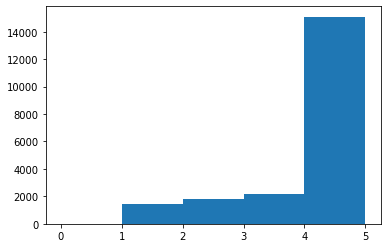

In [ ]:

plt.hist(y, bins = [0,1,2,3,4,5])

In [ ]:
# Check how many training examples in each category
# Distribution of sentiment labels on training set
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)))

[[   1    2    3    4    5]
 [ 876 1088 1253 3598 5479]]


(array([ 876., 1088., 1253., 3598., 5479.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

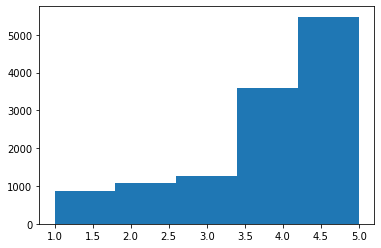

In [ ]:
plt.hist(y_train, bins=5)

In [ ]:
# Distribution of sentiment labels on test set
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)))


[[   1    2    3    4    5]
 [ 545  705  931 2441 3575]]


(array([   0.,  545.,  705.,  931., 6016.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

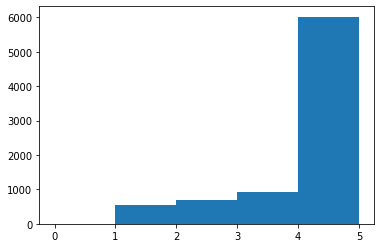

In [ ]:
plt.hist(y_test, bins = [0,1,2,3,4,5])

# Step 3: Vectorization

In [ ]:
# sklearn contains two vectorizers

# CountVectorizer can give you Boolean or TF vectors
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# TfidfVectorizer can give you TF or TFIDF vectors
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# Read the sklearn documentation to understand all vectorization options

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# several commonly used vectorizer setting

#  unigram boolean vectorizer, set minimum document frequency to 5
unigram_bool_vectorizer = CountVectorizer(encoding='latin-1', binary=True, min_df=5, stop_words='english')

#  unigram term frequency vectorizer, set minimum document frequency to 5
unigram_count_vectorizer = CountVectorizer(encoding='latin-1', binary=False, min_df=5, stop_words='english')

#  unigram and trigram term frequency vectorizer, set minimum document frequency to 5
trigram_count_vectorizer = CountVectorizer(encoding='latin-1', ngram_range=(1,3), min_df=5, stop_words='english')

#  unigram tfidf vectorizer, set minimum document frequency to 5
unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, stop_words='english')


## Step 3.1: Vectorize the training data

In [ ]:
'''Unigram count vectorizer'''
# fit vocabulary in training documents and transform the training documents into vectors
X_train_vec = unigram_count_vectorizer.fit_transform(X_train)

# check the content of a document vector
print(X_train_vec.shape)
print(X_train_vec[0].toarray())

# check the size of the constructed vocabulary
print(len(unigram_count_vectorizer.vocabulary_))

# print out the first 10 items in the vocabulary
print(list(unigram_count_vectorizer.vocabulary_.items())[:10])

(12294, 6840)
[[0 0 0 ... 0 0 0]]
6840
[('earth', 1918), ('really', 4819), ('think', 6122), ('word', 6777), ('break', 737), ('dirty', 1700), ('smelly', 5549), ('room', 5122), ('toilet', 6185), ('area', 324)]


In [ ]:
'''trigram count vectorizer'''
# fit vocabulary in training documents and transform the training documents into vectors
X_train_vec_trigram = trigram_count_vectorizer.fit_transform(X_train)

# check the content of a document vector
print(X_train_vec_trigram.shape)
print(X_train_vec_trigram[0].toarray())

# check the size of the constructed vocabulary
print(len(trigram_count_vectorizer.vocabulary_))

# print out the first 10 items in the vocabulary
print(list(trigram_count_vectorizer.vocabulary_.items())[:10])

(12294, 41828)
[[0 0 0 ... 0 0 0]]
41828
[('earth', 9936), ('really', 27911), ('think', 37094), ('word', 41460), ('break', 3981), ('dirty', 9167), ('smelly', 33562), ('room', 29994), ('toilet', 37730), ('area', 947)]


In [ ]:
'''TFIDF vectorizer'''
# fit vocabulary in training documents and transform the training documents into vectors
X_train_vec_tfidf = unigram_tfidf_vectorizer.fit_transform(X_train)

# check the content of a document vector
print(X_train_vec_tfidf.shape)
print(X_train_vec_tfidf[0].toarray())

# check the size of the constructed vocabulary
print(len(unigram_tfidf_vectorizer.vocabulary_))

# print out the first 10 items in the vocabulary
print(list(unigram_tfidf_vectorizer.vocabulary_.items())[:10])


(12294, 6840)
[[0. 0. 0. ... 0. 0. 0.]]
6840
[('earth', 1918), ('really', 4819), ('think', 6122), ('word', 6777), ('break', 737), ('dirty', 1700), ('smelly', 5549), ('room', 5122), ('toilet', 6185), ('area', 324)]


## Step 3.2: Vectorize the bal training data

In [ ]:
# Resample each vectorizer iteration to balance data set

ros = RandomOverSampler(random_state=42)

X_train_vec_bal, y_train_bal = ros.fit_resample(X_train_vec.toarray(), y_train)
X_train_vec_trigram_bal, y_train_bal = ros.fit_resample(X_train_vec_trigram.toarray(), y_train)
X_train_vec_tfidf_bal, y_train_bal = ros.fit_resample(X_train_vec_tfidf.toarray(), y_train)

print(len(y_train))
print(len(y_train_bal))

print(X_train_vec.shape[0])
print(X_train_vec_bal.shape[0])

# summarize distribution
counter = Counter(y_train_bal)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

## Step 3.2: Vectorize the test data

In [ ]:
'''Unigram count vectorizer'''
# use the vocabulary constructed from the training data to vectorize the test data. 
# Therefore, use "transform" only, not "fit_transform", 
# otherwise "fit" would generate a new vocabulary from the test data

X_test_vec = unigram_count_vectorizer.transform(X_test)

# print out #examples and #features in the test set
print(X_test_vec.shape)

In [ ]:
'''trigram Vectorizer'''
# use the vocabulary constructed from the training data to vectorize the test data. 
# Therefore, use "transform" only, not "fit_transform", 
# otherwise "fit" would generate a new vocabulary from the test data

X_test_vec_trigram = trigram_count_vectorizer.transform(X_test)

# print out #examples and #features in the test set
print(X_test_vec_trigram.shape)

In [ ]:
'''TFIDF Vectorizer'''
# use the vocabulary constructed from the training data to vectorize the test data. 
# Therefore, use "transform" only, not "fit_transform", 
# otherwise "fit" would generate a new vocabulary from the test data

X_test_vec_tfidf = unigram_tfidf_vectorizer.transform(X_test)

# print out #examples and #features in the test set
print(X_test_vec_tfidf.shape)

# Step 4: Train a MNB classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
'''MNB Model using TFIDF vectorizer'''

# initialize the MNB model
nb_clf= MultinomialNB()
nb_clf_trigram = MultinomialNB()
nb_clf_tfidf = MultinomialNB()


nb_clf_bal= MultinomialNB()
nb_clf_trigram_bal = MultinomialNB()
nb_clf_tfidf_bal = MultinomialNB()

# use the training data to train the MNB model
nb_clf.fit(X_train_vec, y_train)  
nb_clf_trigram.fit(X_train_vec_trigram, y_train)  
nb_clf_tfidf.fit(X_train_vec_tfidf, y_train)  


nb_clf_bal.fit(X_train_vec_bal, y_train_bal)  
nb_clf_trigram_bal.fit(X_train_vec_trigram_bal, y_train_bal)  
nb_clf_tfidf_bal.fit(X_train_vec_tfidf_bal, y_train_bal)  




In [ ]:
'''Unigram Feature Ranks - Negative '''
feature_ranks = sorted(zip(nb_clf.feature_log_prob_[0], unigram_count_vectorizer.get_feature_names_out()))
very_negative_features = feature_ranks[:10]
print("Very negative words")
for i in range(0, len(very_negative_features)):
    print(very_negative_features[i])

In [ ]:
'''Unigram Feature Ranks - Positive '''
feature_ranks = sorted(zip(nb_clf.feature_log_prob_[4], unigram_count_vectorizer.get_feature_names_out()))
very_positive_features = feature_ranks[-10:]
print("Very positive words")
for i in range(0, len(very_positive_features)):
    print(very_positive_features[i])
print()

In [ ]:
'''trigram Feature Ranks - Negative '''
feature_ranks = sorted(zip(nb_clf_trigram.feature_log_prob_[0],trigram_count_vectorizer.get_feature_names_out()))
very_negative_features = feature_ranks[:10]
print("Very negative words")
for i in range(0, len(very_negative_features)):
    print(very_negative_features[i])

In [ ]:
'''trigram Feature Ranks - Positive '''
feature_ranks = sorted(zip(nb_clf_trigram.feature_log_prob_[4], trigram_count_vectorizer.get_feature_names_out()))
very_positive_features = feature_ranks[-10:]
print("Very positive words")
for i in range(0, len(very_positive_features)):
    print(very_positive_features[i])
print()

In [ ]:
'''TFIDF Feature Ranks - Negative '''
feature_ranks = sorted(zip(nb_clf_tfidf.feature_log_prob_[0], unigram_tfidf_vectorizer.get_feature_names_out()))
very_negative_features = feature_ranks[-10:]
print("Very negative words")
for i in range(0, len(very_negative_features)):
    print(very_negative_features[i])
print()

In [ ]:
'''TFIDF Feature Ranks - Positive '''
feature_ranks = sorted(zip(nb_clf_tfidf.feature_log_prob_[4], unigram_tfidf_vectorizer.get_feature_names_out()))
very_positive_features = feature_ranks[-10:]
print("Very positive words")
for i in range(0, len(very_positive_features)):
    print(very_positive_features[i])
print()

In [ ]:
# test the classifier on the test data set, print accuracy score

print('Unigram Score: ',nb_clf.score(X_test_vec, y_test))
print('Trigram Score: ',nb_clf_trigram.score(X_test_vec_trigram, y_test))
print('TFIDF Score: ',nb_clf_tfidf.score(X_test_vec_tfidf, y_test))

print('Unigram Bal Score: ',nb_clf_bal.score(X_test_vec.toarray(), y_test))
print('Trigram Bal Score: ',nb_clf_trigram_bal.score(X_test_vec_trigram.toarray(), y_test))
print('TFIDF Bal Score: ',nb_clf_tfidf_bal.score(X_test_vec_tfidf.toarray(), y_test))



In [ ]:
# Create lists to append returned values for model comparison at the end
model_name = []
model_type = []
vector_type = []
sample_type = []
data_type = []
accuracy = []
precision_wavg = []
recall_wavg = []
f1_wavg = []

In [ ]:
'''Unigram '''
# print confusion matrix (row: ground truth; col: prediction)

from sklearn.metrics import confusion_matrix
nb_y_pred = nb_clf.predict(X_test_vec)
cm=confusion_matrix(y_test, nb_y_pred, labels=[0,1,2,3,4])
print(cm)

# print classification report
### Unigram Count
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
print(classification_report(y_test, nb_y_pred, target_names=target_names))

report = classification_report(y_test, nb_y_pred, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('MNB-1C')
model_type.append('MNB')
vector_type.append('Unigram Count')
sample_type.append('Hold-Out: '+ str(test_size))
data_type.append('Original')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])


In [ ]:

nb_y_pred_bal = nb_clf_bal.predict(X_test_vec)
cm=confusion_matrix(y_test, nb_y_pred_bal, labels=[0,1,2,3,4])
print(cm)


target_names = ['1','2','3','4','5']
print(classification_report(y_test, nb_y_pred_bal, target_names=target_names))

report = classification_report(y_test, nb_y_pred_bal, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('MNB-1C')
model_type.append('MNB')
vector_type.append('Unigram Count')
sample_type.append('Hold-Out: '+ str(test_size))
data_type.append('Balanced')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

In [ ]:
'''trigram '''
# print confusion matrix (row: ground truth; col: prediction)

nb_y_pred_trigram = nb_clf_trigram.predict(X_test_vec_trigram)
cm=confusion_matrix(y_test, nb_y_pred_trigram, labels=[0,1,2,3,4])
print(cm)

# print classification report
target_names = ['1','2','3','4','5']
print(classification_report(y_test, nb_y_pred_trigram, target_names=target_names))

report = classification_report(y_test, nb_y_pred_trigram, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('MNB-3C')
model_type.append('MNB')
vector_type.append('trigram Count')
sample_type.append('Hold-Out: '+ str(test_size))
data_type.append('Original')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

In [ ]:
# print confusion matrix (row: ground truth; col: prediction)

nb_y_pred_trigram_bal = nb_clf_trigram_bal.predict(X_test_vec_trigram)
cm=confusion_matrix(y_test, nb_y_pred_trigram_bal, labels=[0,1,2,3,4])
print(cm)

# print classification report
target_names = ['1','2','3','4','5']
print(classification_report(y_test, nb_y_pred_trigram_bal, target_names=target_names))

report = classification_report(y_test, nb_y_pred_trigram_bal, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('MNB-3C')
model_type.append('MNB')
vector_type.append('trigram Count')
sample_type.append('Hold-Out: '+ str(test_size))
data_type.append('Balanced')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

In [ ]:
'''TFIDF '''
# print confusion matrix (row: ground truth; col: prediction)

nb_y_pred_tfidf = nb_clf_tfidf.predict(X_test_vec_tfidf)
cm=confusion_matrix(y_test, nb_y_pred_tfidf, labels=[0,1,2,3,4])
print(cm)

# print classification report
target_names = ['1','2','3','4','5']
print(classification_report(y_test, nb_y_pred_tfidf, target_names=target_names))

report = classification_report(y_test, nb_y_pred_tfidf, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('MNB-TFIDF')
model_type.append('MNB')
vector_type.append('TFIDF')
sample_type.append('Hold-Out: '+ str(test_size))
data_type.append('Original')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

In [ ]:
# print confusion matrix (row: ground truth; col: prediction)

nb_y_pred_tfidf_bal = nb_clf_tfidf_bal.predict(X_test_vec_tfidf)
cm=confusion_matrix(y_test, nb_y_pred_tfidf_bal, labels=[0,1,2,3,4])
print(cm)

# print classification report
target_names = ['1','2','3','4','5']
print(classification_report(y_test, nb_y_pred_tfidf_bal, target_names=target_names))

report = classification_report(y_test, nb_y_pred_tfidf_bal, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('MNB-TFIDF')
model_type.append('MNB')
vector_type.append('TFIDF')
sample_type.append('Hold-Out: '+ str(test_size))
data_type.append('Balanced')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

# Train SVM Model

In [ ]:
'''SVN model using trigram count vectorizer'''
# import the LinearSVC module
from sklearn.svm import LinearSVC

# initialize the LinearSVC model
svm_clf = LinearSVC(C=1)
svm_clf_trigram = LinearSVC(C=1)
svm_clf_tfidf = LinearSVC(C=1)

svm_clf_bal = LinearSVC(C=1)
svm_clf_trigram_bal = LinearSVC(C=1)
svm_clf_tfidf_bal = LinearSVC(C=1)


# use the training data to train the model
svm_clf.fit(X_train_vec,y_train)
svm_clf_trigram.fit(X_train_vec_trigram,y_train)
svm_clf_tfidf.fit(X_train_vec_tfidf,y_train)

svm_clf_bal.fit(X_train_vec_bal,y_train_bal)
svm_clf_trigram_bal.fit(X_train_vec_trigram_bal,y_train_bal)
svm_clf_tfidf_bal.fit(X_train_vec_tfidf_bal,y_train_bal)



In [ ]:
'''Unigram Feature Ranks - Negative '''
feature_ranks = sorted(zip(svm_clf.coef_[0], unigram_count_vectorizer.get_feature_names_out()))
very_negative_features = feature_ranks[:10]
print("Very negative words")
for i in range(0, len(very_negative_features)):
    print(very_negative_features[i])

In [ ]:
'''Unigram Feature Ranks - Positive '''
feature_ranks = sorted(zip(svm_clf.coef_[4], unigram_count_vectorizer.get_feature_names_out()))
very_positive_features = feature_ranks[-10:]
print("Very positive words")
for i in range(0, len(very_positive_features)):
    print(very_positive_features[i])
print()

In [ ]:
'''trigram Feature Ranks - Negative '''
feature_ranks = sorted(zip(svm_clf_trigram.coef_[0],trigram_count_vectorizer.get_feature_names_out()))
very_negative_features = feature_ranks[:10]
print("Very negative words")
for i in range(0, len(very_negative_features)):
    print(very_negative_features[i])

In [ ]:
'''trigram Feature Ranks - Positive '''
feature_ranks = sorted(zip(svm_clf_trigram.coef_[4], trigram_count_vectorizer.get_feature_names_out()))
very_positive_features = feature_ranks[-10:]
print("Very positive words")
for i in range(0, len(very_positive_features)):
    print(very_positive_features[i])
print()

In [ ]:
'''TFIDF Feature Ranks - Negative '''
feature_ranks = sorted(zip(svm_clf_tfidf.coef_[0], unigram_tfidf_vectorizer.get_feature_names_out()))
very_negative_features = feature_ranks[-10:]
print("Very negative words")
for i in range(0, len(very_negative_features)):
    print(very_negative_features[i])
print()

In [ ]:
'''TFIDF Feature Ranks - Positive '''
feature_ranks = sorted(zip(svm_clf_tfidf.coef_[4], unigram_tfidf_vectorizer.get_feature_names_out()))
very_positive_features = feature_ranks[-10:]
print("Very positive words")
for i in range(0, len(very_positive_features)):
    print(very_positive_features[i])
print()

In [ ]:
# test the classifier on the test data set, print accuracy score

print('Unigram Score: ',svm_clf.score(X_test_vec,y_test))
print('trigram Score: ',svm_clf_trigram.score(X_test_vec_trigram,y_test))
print('TFIDF Score: ',svm_clf_tfidf.score(X_test_vec_tfidf,y_test))

print('Unigram Bal Score: ',svm_clf_bal.score(X_test_vec,y_test))
print('trigram Bal Score: ',svm_clf_trigram_bal.score(X_test_vec_trigram,y_test))
print('TFIDF Bal Score: ',svm_clf_tfidf_bal.score(X_test_vec_tfidf,y_test))

In [ ]:
''' Unigram'''
# print confusion matrix and classification report
svm_y_pred = svm_clf.predict(X_test_vec)
cm=confusion_matrix(y_test, svm_y_pred, labels=[0,1,2,3,4])
print(cm)
print()

target_names = ['1','2','3','4','5']
print(classification_report(y_test, svm_y_pred, target_names=target_names))

report = classification_report(y_test, svm_y_pred, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('SVM-1C')
model_type.append('SVM')
vector_type.append('Unigram Count')
sample_type.append('Hold-Out: ' + str(test_size))
data_type.append('Original')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

In [ ]:
svm_y_pred_bal = svm_clf_bal.predict(X_test_vec)
cm=confusion_matrix(y_test, svm_y_pred_bal, labels=[0,1,2,3,4])
print(cm)
print()

target_names = ['1','2','3','4','5']
print(classification_report(y_test, svm_y_pred_bal, target_names=target_names))

report = classification_report(y_test, svm_y_pred_bal, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('SVM-1C')
model_type.append('SVM')
vector_type.append('Unigram Count')
sample_type.append('Hold-Out: ' + str(test_size))
data_type.append('Balanced')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

In [ ]:
''' trigram'''
# print confusion matrix and classification report

svm_y_pred_trigram = svm_clf_trigram.predict(X_test_vec_trigram)
cm=confusion_matrix(y_test, svm_y_pred_trigram, labels=[0,1,2,3,4])
print(cm)
print()

target_names = ['1','2','3','4','5']
print(classification_report(y_test, svm_y_pred_trigram, target_names=target_names))

report = classification_report(y_test, svm_y_pred_trigram, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('SVM-3C')
model_type.append('SVM')
vector_type.append('trigram Count')
sample_type.append('Hold-Out: ' + str(test_size))
data_type.append('Original')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

In [ ]:
# print confusion matrix and classification report

svm_y_pred_trigram_bal = svm_clf_trigram_bal.predict(X_test_vec_trigram)
cm=confusion_matrix(y_test, svm_y_pred_trigram_bal, labels=[0,1,2,3,4])
print(cm)
print()

target_names = ['1','2','3','4','5']
print(classification_report(y_test, svm_y_pred_trigram_bal, target_names=target_names))

report = classification_report(y_test, svm_y_pred_trigram_bal, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('SVM-3C')
model_type.append('SVM')
vector_type.append('trigram Count')
sample_type.append('Hold-Out: ' + str(test_size))
data_type.append('Balanaced')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

In [ ]:
''' TFIDF'''
# print confusion matrix and classification report

svm_y_pred_tfidf = svm_clf_tfidf.predict(X_test_vec_tfidf)
cm=confusion_matrix(y_test, svm_y_pred_tfidf, labels=[0,1,2,3,4])
print(cm)
print()

target_names = ['1','2','3','4','5']
print(classification_report(y_test, svm_y_pred_tfidf, target_names=target_names))

report = classification_report(y_test, svm_y_pred_tfidf, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('SVM-TFIDF')
model_type.append('SVM')
vector_type.append('TFIDF')
sample_type.append('Hold-Out: '+ str(test_size))
data_type.append('Original')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

In [ ]:
# print confusion matrix and classification report

svm_y_pred_tfidf_bal = svm_clf_tfidf_bal.predict(X_test_vec_tfidf)
cm=confusion_matrix(y_test, svm_y_pred_tfidf_bal, labels=[0,1,2,3,4])
print(cm)
print()

target_names = ['1','2','3','4','5']
print(classification_report(y_test, svm_y_pred_tfidf_bal, target_names=target_names))

report = classification_report(y_test, svm_y_pred_tfidf_bal, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('SVM-TFIDF')
model_type.append('SVM')
vector_type.append('TFIDF')
sample_type.append('Hold-Out: '+ str(test_size))
data_type.append('Balanaced')
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

# Bernoulli NB



In [ ]:
# fit vocabulary in training documents and transform the training documents into vectors
X_train_bool = unigram_bool_vectorizer.fit_transform(X_train)

# check the content of a document vector
print(X_train_bool.shape)
print(X_train_bool[0].toarray())

# check the size of the constructed vocabulary
print(len(unigram_bool_vectorizer.vocabulary_))

# print out the first 10 items in the vocabulary
print(list(unigram_bool_vectorizer.vocabulary_.items()))

In [ ]:
# use the vocabulary constructed from the training data to vectorize the test data. 
X_test_bool = unigram_bool_vectorizer.transform(X_test)

# print out #examples and #features in the test set
print(X_test_bool.shape)

In [ ]:
from sklearn.naive_bayes import BernoulliNB
# X_train_vec_bool = unigram_bool_vectorizer.fit_transform(X_train)
bernoulliNB_clf = BernoulliNB()

# use the training data to train the MNB model
bernoulliNB_clf.fit(X_train_bool,y_train) 

In [ ]:
# print confusion matrix (row: ground truth; col: prediction)
### bool

y_pred_bool = bernoulliNB_clf.fit(X_train_bool, y_train).predict(X_test_bool)
cm=confusion_matrix(y_test, y_pred_bool, labels=[1,2,3,4,5])
print(cm)

# print classification report 
### bool

from sklearn.metrics import classification_report
target_names = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred_bool, target_names=target_names))

report = classification_report(y_test, y_pred_bool, target_names=target_names,output_dict=True)

# Append model values to apply to a dataframe to compare model performance
model_name.append('NB Bern')
model_type.append('Bernoulli')
vector_type.append('Boolean')
sample_type.append('Hold-Out: '+ str(test_size))
accuracy.append(report['accuracy'])
precision_wavg.append(report['weighted avg']['precision'])
recall_wavg.append(report['weighted avg']['recall'])
f1_wavg.append(report['weighted avg']['f1-score'])

# Step 6: write the prediction output to file

In [ ]:
# y_pred=nb_clf.predict(X_test_vec)
# output = open('/Users/michaelharper/prediction_output.csv', 'w')
# for x, value in enumerate(y_pred):
#   output.write(str(value) + '\n') 
# output.close()

# Cross Validation

In [ ]:
'''Unigram MNB'''
# cross validation NB

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
nb_clf_pipe = Pipeline([('vect', unigram_count_vectorizer),('nb', MultinomialNB())])
scores = cross_val_score(nb_clf_pipe, X, y, cv=10)
avg=sum(scores)/len(scores)
print(avg)

model_name.append('MNB-1C_CV')
model_type.append('MNB')
vector_type.append('Unigram Count')
sample_type.append('10-CV')
accuracy.append(avg)

In [ ]:
'''trigram MNB'''
# cross validation NB

nb_clf_trigram_pipe = Pipeline([('vect', trigram_count_vectorizer),('nb', MultinomialNB())])
scores = cross_val_score(nb_clf_trigram_pipe, X, y, cv=10)
avg=sum(scores)/len(scores)
print(avg)

model_name.append('MNB-3C_CV')
model_type.append('MNB')
vector_type.append('trigram Count')
sample_type.append('10-CV')
accuracy.append(avg)

In [ ]:
'''TFIDF MNB'''
# cross validation NB

nb_clf_tfidf_pipe = Pipeline([('vect', unigram_tfidf_vectorizer),('nb', MultinomialNB())])
scores = cross_val_score(nb_clf_tfidf_pipe, X, y, cv=10)
avg=sum(scores)/len(scores)
print(avg)

model_name.append('MNB-TFIDF_CV')
model_type.append('MNB')
vector_type.append('TFIDF')
sample_type.append('10-CV')
accuracy.append(avg)

In [ ]:
'''Unigram SVM'''
# cross validation SVM

svm_clf_pipe = Pipeline([('vect', unigram_count_vectorizer),('svm', LinearSVC(C=0.5))])
scores = cross_val_score(svm_clf_pipe, X, y, cv=10)
avg=sum(scores)/len(scores)
print(avg)

# Append model values to apply to a dataframe to compare model performance
model_name.append('SVM-1C_CV')
model_type.append('SVM')
vector_type.append('Unigram Count')
sample_type.append('10-CV')
accuracy.append(avg)

In [ ]:
'''trigram SVM'''
# cross validation SVM

svm_clf_trigram_pipe = Pipeline([('vect', trigram_count_vectorizer),('svm', LinearSVC(C=0.5))])
scores = cross_val_score(svm_clf_trigram_pipe, X, y, cv=10)
avg=sum(scores)/len(scores)
print(avg)

# Append model values to apply to a dataframe to compare model performance
model_name.append('SVM-3C_CV')
model_type.append('SVM')
vector_type.append('trigram Count')
sample_type.append('10-CV')
accuracy.append(avg)

In [ ]:
'''TFIDF SVM'''
# cross validation SVM

svm_clf_tfidf_pipe = Pipeline([('vect', unigram_tfidf_vectorizer),('svm', LinearSVC(C=0.5))])
scores = cross_val_score(svm_clf_tfidf_pipe, X, y, cv=10)
avg=sum(scores)/len(scores)
print(avg)

# Append model values to apply to a dataframe to compare model performance
model_name.append('SVM-TFIDF_CV')
model_type.append('SVM')
vector_type.append('TFIDF')
sample_type.append('10-CV')
accuracy.append(avg)

In [ ]:
''' BernoulliNB '''

# cross validation SVM

nb_bern_pipe = Pipeline([('vect', unigram_bool_vectorizer),('nb', BernoulliNB())])
scores = cross_val_score(nb_bern_pipe, X, y, cv=10)
avg=sum(scores)/len(scores)
print(avg)

# Append model values to apply to a dataframe to compare model performance
model_name.append('NB-Bern_CV')
model_type.append('SVM')
vector_type.append('Bernoulli')
sample_type.append('10-CV')
accuracy.append(avg)


In [ ]:
# Create a dataframe from dictionary of saved model scores
dict = {'Model Name': model_name, 'Model Type': model_type, 'Vector Type':vector_type,'Sample Type': sample_type,'Accuracy': accuracy, 'Avg Precision':precision_wavg, 'Avg Recall':recall_wavg, 'Avg F1':f1_wavg}

comp_df = pd.DataFrame.from_dict(dict, orient='index')
comp_df = comp_df.transpose()

# CSV output
comp_df.to_csv("drive/Shareddrives/IST_736_Final_Project/Model_Scores.csv")
# Show
comp_df

In [ ]:
# Accuracy by Model
import seaborn as sns
ax = sns.barplot(data=comp_df,x='Model Name', y ='Accuracy')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha='right')
plt.ylim(bottom= min(comp_df['Accuracy'])*.9)
plt.title('Accuracy by Model')
plt.show()

In [ ]:
# Determine highest Accuracy Score
max_accuracy = comp_df[comp_df['Accuracy'] == max(comp_df['Accuracy'])]
print('Model w/ the highest accuracy score: ', max_accuracy[['Model Name','Accuracy']])
# Determine highest F1 Score
ho_df = comp_df[comp_df['Sample Type']== ('Hold-Out: ' + str(test_size))]
max_f1 = ho_df[ho_df['Avg F1'] == max(ho_df['Avg F1'])]
print('Model w/ the highest F1 score: ', max_f1[['Model Name','Avg F1']])
